In [219]:
import pandas as pd
import numpy as np
import glob
import requests
import json
import gc
import pickle

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score
from imblearn.under_sampling import TomekLinks

from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

RND_STATE = 100412

In [ ]:
def log_progress(sequence, every=None, size=None, name='Items'):
    from ipywidgets import IntProgress, HTML, VBox
    from IPython.display import display

    is_iterator = False
    if size is None:
        try:
            size = len(sequence)
        except TypeError:
            is_iterator = True
    if size is not None:
        if every is None:
            if size <= 200:
                every = 1
            else:
                every = int(size / 200)     # every 0.5%
    else:
        assert every is not None, 'sequence is iterator, set every'

    if is_iterator:
        progress = IntProgress(min=0, max=1, value=1)
        progress.bar_style = 'info'
    else:
        progress = IntProgress(min=0, max=size, value=0)
    label = HTML()
    box = VBox(children=[label, progress])
    display(box)

    index = 0
    try:
        for index, record in enumerate(sequence, 1):
            if index == 1 or index % every == 0:
                if is_iterator:
                    label.value = '{name}: {index} / ?'.format(
                        name=name,
                        index=index
                    )
                else:
                    progress.value = index
                    label.value = u'{name}: {index} / {size}'.format(
                        name=name,
                        index=index,
                        size=size
                    )
            yield record
    except:
        progress.bar_style = 'danger'
        raise
    else:
        progress.bar_style = 'success'
        progress.value = index
        label.value = "{name}: {index}".format(
            name=name,
            index=str(index or '?')
        )

## Configuration

In [3]:
# weather links
# ftp://ftp.ncdc.noaa.gov/pub/data/ghcn/daily/readme.txt

In [4]:
WEATHER_API_KEY = ''

In [5]:
STARTING_DATE = '2017-03-01'
END_DATE = '2018-03-01'

In [6]:
DATA_FOLDER = 'historical_data'
DICT_FOLDER = 'dictionaries'
WEATHER_FOLDER = 'weather_data'

In [7]:
DATA_FILE = 'merged_data.csv'

In [161]:
CLF_FILE = 'classifiers.data'

## Merging and loading data

### Loading flights data

In [8]:
def get_file_list(folder_name):
    return glob.glob(folder_name + '/*.csv')

In [9]:
def read_csv(file_name):
    file_data = pd.read_csv(file_name, dtype={'CANCELLATION_CODE': str}, parse_dates=True)
    file_data['FL_DATE'] = pd.to_datetime(file_data.FL_DATE)
    return file_data

In [10]:
def read_csv_backup(file_name):
    file_data = pd.read_csv(file_name, dtype={'cancellation_code': str}, parse_dates=True)
    file_data['fl_date'] = pd.to_datetime(file_data.fl_date)
    file_data = file_data.drop(['Unnamed: 0'], axis = 1)
    return file_data

In [11]:
def gather_data(folder_name):
    file_list = get_file_list(folder_name)
    
    files_data = read_csv(file_list[0])
    for file in log_progress(file_list[1:], every=1):
        tmp = read_csv(file)
        files_data = pd.concat([files_data, tmp])
        del tmp
        
    files_data = files_data.reindex()
    files_data.columns = map(str.lower, files_data.columns)
    return files_data

In [12]:
def append_city_names(files_data, dict_folder_name):
    files_data_df = files_data.copy()
    city_info = pd.read_csv(dict_folder_name + '/city_codes_info.csv')
    city_info['Description'] =  city_info['Description'].str.replace(',.*|\/.*| City', '')
    
    city_info.columns = ['origin_city_market_id', 'origin_city_name']
    files_data_df = pd.merge(files_data_df, city_info, on='origin_city_market_id')
    
    city_info.columns = ['dest_city_market_id', 'dest_city_name']
    files_data_df = pd.merge(files_data_df, city_info, on='dest_city_market_id')
    
    del city_info
    
    return files_data_df

In [13]:
def load_data(folder_name, dict_folder_name):
    files_data = gather_data(folder_name)
    files_data = files_data.sort_values(by='fl_date')
    files_data = files_data.dropna(thresh=9)
    files_data = append_city_names(files_data, dict_folder_name)
    return files_data.reindex()

In [ ]:
data = load_data(DATA_FOLDER, DICT_FOLDER)

In [ ]:
data.to_csv(DATA_FILE)

### Loading weather data

In [14]:
def get_data_city_names(data_df):
    return list(set(list(data['origin_city_name'].values) + list(data['dest_city_name'].values)))

In [15]:
def load_city_codes(dict_folder_name):
    tmp = pd.read_csv(dict_folder_name + '/weather_city_codes_info.csv')
    tmp['name'] = tmp['name'].str.lower()
    tmp['name'] = tmp['name'].str.replace(',.*|\/.*| city', '')
    tmp['name'] = tmp['name'].str.strip()
    return tmp

In [16]:
def get_weather_city_codes(data_df, dict_folder_name):
    weather_cities_codes = load_city_codes(dict_folder_name)
    data_city_names = get_data_city_names(data_df)
    
    processed_cities = []
    failed_cities = []
    for city in data_city_names:
        city_data = weather_cities_codes[weather_cities_codes['name'].str.contains(city.lower())]
        if len(city_data) == 0:
            failed_cities.append(city)
        else:
            processed_cities.append({'name': city, 'weather_id': city_data['id'].values[0]})
    return processed_cities, failed_cities

In [17]:
def get_weather_for_city(city_info, start_date, end_date, api_key, limit=1000, offset=0):
    req_url = 'http://www.ncdc.noaa.gov/cdo-web/api/v2/data?datasetid=GHCND&locationid={0}&startdate={1}&enddate={2}&limit={3}&offset={4}'
    req_url = req_url.format(city_info['weather_id'], start_date, end_date, limit, offset)
    
    result_json = requests.get(req_url, headers={'token': api_key}, timeout=20)
    result_json = json.loads(result_json.content)
    result_data = pd.DataFrame(result_json['results'])
    
    if result_json['metadata']['resultset']['count'] > offset + limit:
        return pd.concat([result_data, get_weather_for_city(city_info, start_date, end_date, api_key, limit, offset + limit)])
    else:
        return result_data

In [18]:
def save_weather_data(data_df, dict_folder_name, save_folder, start_date, end_date, api_key):
    weather_city_codes, error_cities = get_weather_city_codes(data_df, dict_folder_name)
    
    for city in log_progress(weather_city_codes, every=1):
        try:
            city_weather = get_weather_for_city(city, start_date, end_date, api_key)
            city_weather.to_csv(save_folder + '/' + city['name'] + '.csv')
        except Exception as e:
            error_cities.append(city)
            print(e)
    return weather_city_codes, error_cities

In [ ]:
ok, err = save_weather_data(data, DICT_FOLDER, WEATHER_FOLDER, STARTING_DATE, END_DATE, WEATHER_API_KEY)

In [19]:
def filter_data_by_available_weather(data_df, weather_data_folder):
    city_list = get_file_list(weather_data_folder)
    fixed_city_list = []
    for city in city_list:
        fixed_city_list.append(city.replace(weather_data_folder + '/', '').replace('.csv', ''))
    
    tmp_df = data_df[(data_df['origin_city_name'].isin(fixed_city_list)) | (data_df['dest_city_name'].isin(fixed_city_list))]
    return tmp_df, city_list 

In [20]:
def read_weather_file(weather_data_folder, weather_file_path):
    weather_data = pd.read_csv(weather_file_path)
    weather_data['date'] = pd.to_datetime(weather_data.date)
    weather_data = weather_data.drop(['Unnamed: 0', 'attributes', 'station'], axis=1)
    weather_data = weather_data.rename(columns={'date': 'fl_date'})
    weather_data = weather_data.drop_duplicates(["fl_date", "datatype"])
    weather_data = weather_data.pivot_table(weather_data, index='fl_date', columns='datatype', aggfunc=sum, fill_value=0)
    weather_data = weather_data.reset_index()
    weather_data_value = weather_data['value'].copy()
    weather_data_value['fl_date'] = weather_data['fl_date']
    del weather_data
    selected_cols = ['fl_date', 'AWND', 'SNOW', 'SNWD', 'WT01', 'WT02', 'WT03', 'WT04', 'WT05', 'WT06', 'WT07', 'WT08', 'WT09', 'WT10', 'WT11']
    available_cols = list(set(weather_data_value.columns).intersection(selected_cols))
    na_cols = list(set(selected_cols) - set(available_cols))
    weather_data_value = weather_data_value[available_cols]
    
    for na_col in na_cols:
        weather_data_value[na_col] = None
    
    weather_data_value = weather_data_value.rename({'SNOW': 'snowfall_mm', 'SNWD': 'snow_depth_mm', 'AWND': 'avg_wind_ms', 'WT08': 'smoke', 'WT01': 'fog', 'WT03': 'thunder'})
    weather_data_value['city_name'] = weather_file_path.replace(weather_data_folder + '/', '').replace('.csv', '')
    
    return weather_data_value

In [ ]:
def merge_data_with_weather(data_df, weather_data_folder):
    filtered_df, city_list = filter_data_by_available_weather(data_df, weather_data_folder)
    dfs = []
    
    for city in log_progress(city_list, every=1):
        tmp = read_weather_file(weather_data_folder, city)
        tmp = tmp.rename(columns={'city_name': 'origin_city_name'})
        dfs.append(pd.merge(filtered_df, tmp, on=['fl_date', 'origin_city_name']))
        tmp = tmp.rename(columns={'origin_city_name': 'dest_city_name'})
        dfs.append(pd.merge(filtered_df, tmp, on=['fl_date', 'dest_city_name']))
        del tmp
        gc.collect()
        
    final_df = pd.concat(dfs)
    final_df = final_df.sort_values(by=['fl_date', 'origin_city_name', 'dest_city_name'])
    return final_df

In [ ]:
data = merge_data_with_weather(data, WEATHER_FOLDER)

In [ ]:
data.to_csv(DATA_FILE)

## Preprocessing data 

In [335]:
data = read_csv_backup(DATA_FILE)

In [336]:
def get_dependent_variable_value(row):
    if row['cancelled'] == 1 or row['cancellation_code'] != 'E':
        return 'cancelled_flight'
    if row['dep_delay_new'] > 300:
        return 'extra_long_delay'
    if row['dep_delay_new'] > 120:
        return 'long_delay'
    if row['dep_delay_new'] > 30:
        return 'moderate_delay'
    if row['dep_delay_new'] < 30:
        return 'short_delay'
    return 'no delay'

In [337]:
def preprocess_data(file_data):
    data_df = file_data.copy()
    data_df = data_df.drop(['origin_airport_id', 'origin_airport_seq_id', 'origin_city_market_id', 'dest_airport_id', 'dest_airport_seq_id', 'dest_city_market_id', 'year', 'quarter', 'unnamed: 25'], axis=1)
    data_df = data_df.fillna(value={'cancellation_code': 'E'})
    data_df = data_df.fillna(0)
    data_df['fog'] = list(map(int , (data_df['WT01'] + data_df['WT02']).values > 0))
    data_df['hail'] = list(map(int , (data_df['WT04'] + data_df['WT05']).values > 0))
    data_df['damaging_wind'] = list(map(int , (data_df['WT10'] + data_df['WT11']).values > 0))
    data_df = data_df.drop(['WT01', 'WT02', 'WT04', 'WT05', 'WT06', 'WT10', 'WT11'], axis=1)
    data_df = data_df.rename(columns={'SNOW': 'snowfall', 'SNWD': 'snow_depth', 'AWND': 'average_wind_speed','WT03': 'thunder', 'WT07': 'dust', 'WT08': 'haze', 'WT09': 'snow'})
    
    data_df['cancellation_code'] = list(map(str, data_df['cancellation_code']))
    data_df['carrier'] = list(map(str, data_df['carrier']))
    data_df['dest'] = list(map(str, data_df['dest']))
    data_df['dest_city_name'] = list(map(str, data_df['dest_city_name']))
    data_df['origin'] = list(map(str, data_df['origin']))
    data_df['origin_city_name'] = list(map(str, data_df['origin_city_name']))
    data_df['cancelled'] = list(map(int, data_df['cancelled']))
    data_df['diverted'] = list(map(int, data_df['diverted']))
    data_df['status'] = data_df.apply (lambda row: get_dependent_variable_value(row), axis=1)
    return data_df

In [338]:
data = preprocess_data(data)

## Analysis with additional data

Overall data info

In [25]:
data.describe()

,average_wind_speed,snowfall,snow_depth,thunder,dust,haze,snow,cancelled,carrier_delay,day_of_month,...,diverted,fl_num,late_aircraft_delay,month,nas_delay,security_delay,weather_delay,fog,hail,damaging_wind
count,5.238989e+06,5.238989e+06,5.238989e+06,5.238989e+06,5.238989e+06,5.238989e+06,5.238989e+06,5.238989e+06,5.238989e+06,5.238989e+06,...,5.238989e+06,5.238989e+06,5.238989e+06,5.238989e+06,5.238989e+06,5.238989e+06,5.238989e+06,5.238989e+06,5.238989e+06,5.238989e+06
mean,2.826448e+01,7.622557e-01,5.023249e+00,1.803222e-01,2.383857e-03,1.394170e-01,1.647455e-03,1.505768e-02,3.692147e+00,1.584771e+01,...,2.008594e-03,2.263090e+03,4.375654e+00,6.728145e+00,2.352459e+00,1.722222e-02,5.349526e-01,3.526033e-01,6.513280e-03,4.077886e-03
std,2.504670e+01,9.747686e+00,3.543713e+01,3.844556e-01,4.876653e-02,3.463812e-01,4.055541e-02,1.217824e-01,2.875547e+01,8.825034e+00,...,4.477231e-02,1.744048e+03,2.219222e+01,3.364111e+00,1.500126e+01,1.421076e+00,1.123713e+01,4.777806e-01,8.044164e-02,6.372800e-02
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,...,0.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.500000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,8.000000e+00,...,0.000000e+00,8.640000e+02,0.000000e+00,4.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.600000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.600000e+01,...,0.000000e+00,1.792000e+03,0.000000e+00,7.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,3.800000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.300000e+01,...,0.000000e+00,3.324000e+03,0.000000e+00,1.000000e+01,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00
max,1.073000e+03,8.230000e+02,1.626000e+03,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,2.007000e+03,3.100000e+01,...,1.000000e+00,7.439000e+03,1.756000e+03,1.200000e+01,1.605000e+03,8.270000e+02,1.682000e+03,1.000000e+00,1.000000e+00,1.000000e+00


Correlations

In [26]:
data.corr()

,average_wind_speed,snowfall,snow_depth,thunder,dust,haze,snow,cancelled,carrier_delay,day_of_month,...,diverted,fl_num,late_aircraft_delay,month,nas_delay,security_delay,weather_delay,fog,hail,damaging_wind
average_wind_speed,1.000000,0.034958,0.014490,0.013897,0.023330,0.016884,0.058536,0.046752,0.004227,-0.008078,...,0.002282,0.003636,0.007155,-0.097134,0.006019,-0.001993,0.005551,0.021961,0.050488,0.014574
snowfall,0.034958,1.000000,0.393331,-0.034660,-0.003794,0.024247,0.193429,0.043380,0.005846,-0.008624,...,0.002102,0.019229,0.009540,-0.029349,0.011895,-0.000036,0.015354,0.039218,0.027529,0.029932
snow_depth,0.014490,0.393331,1.000000,-0.065502,-0.006891,0.009965,0.139840,0.017950,0.003020,-0.005113,...,0.002342,0.017860,0.002235,-0.102208,0.002081,0.001163,0.007608,0.005875,0.019769,0.025727
thunder,0.013897,-0.034660,-0.065502,1.000000,0.036549,0.114641,-0.017462,0.008532,0.017658,-0.022096,...,0.021829,-0.030622,0.046634,-0.013115,0.055175,0.000230,0.021173,0.341152,0.053893,0.048229
dust,0.023330,-0.003794,-0.006891,0.036549,1.000000,0.115088,-0.001407,0.000512,0.000544,0.005332,...,0.008210,-0.001244,0.006630,0.007715,0.007674,-0.000336,0.005315,-0.019323,-0.003131,0.004058
haze,0.016884,0.024247,0.009965,0.114641,0.115088,1.000000,0.022076,0.007511,0.005700,-0.013381,...,0.010805,0.000501,0.012587,0.014707,0.017693,0.000376,0.008260,0.249027,0.000347,0.002676
snow,0.058536,0.193429,0.139840,-0.017462,-0.001407,0.022076,1.000000,0.025934,0.003811,-0.017409,...,0.001962,0.018797,0.006246,-0.040625,0.007833,0.000322,0.008555,0.035470,0.051592,0.058256
cancelled,0.046752,0.043380,0.017950,0.008532,0.000512,0.007511,0.025934,1.000000,-0.015876,-0.039801,...,-0.004777,0.009042,-0.024379,-0.022203,-0.019390,-0.001498,-0.005886,0.032258,0.015065,0.013092
carrier_delay,0.004227,0.005846,0.003020,0.017658,0.000544,0.005700,0.003811,-0.015876,1.000000,-0.007327,...,-0.005760,0.019902,0.051072,-0.010387,0.020754,-0.000773,-0.002296,0.011728,0.002183,0.000622
day_of_month,-0.008078,-0.008624,-0.005113,-0.022096,0.005332,-0.013381,-0.017409,-0.039801,-0.007327,1.000000,...,-0.004572,0.008877,-0.015391,-0.003983,-0.012764,-0.001823,-0.014571,-0.025148,0.006574,-0.001226


In [27]:
def check_correlations(data_df, min_v=0.7):
    corr = data_df.corr()
    corrs = []
    for i in corr:
        for j in corr.index[corr[i] >= min_v]:
            if i != j and j not in corrs and i not in corrs:
                corrs.append(j)
                print("%s-->%s: r^2=%f" % (i,j, corr[i][corr.index == j].values[0]))
    if len(corrs) == 0:
        print('Everything is perfect')

In [28]:
check_correlations(data)

carrier_delay-->dep_delay_new: r^2=0.711197


Plotting data

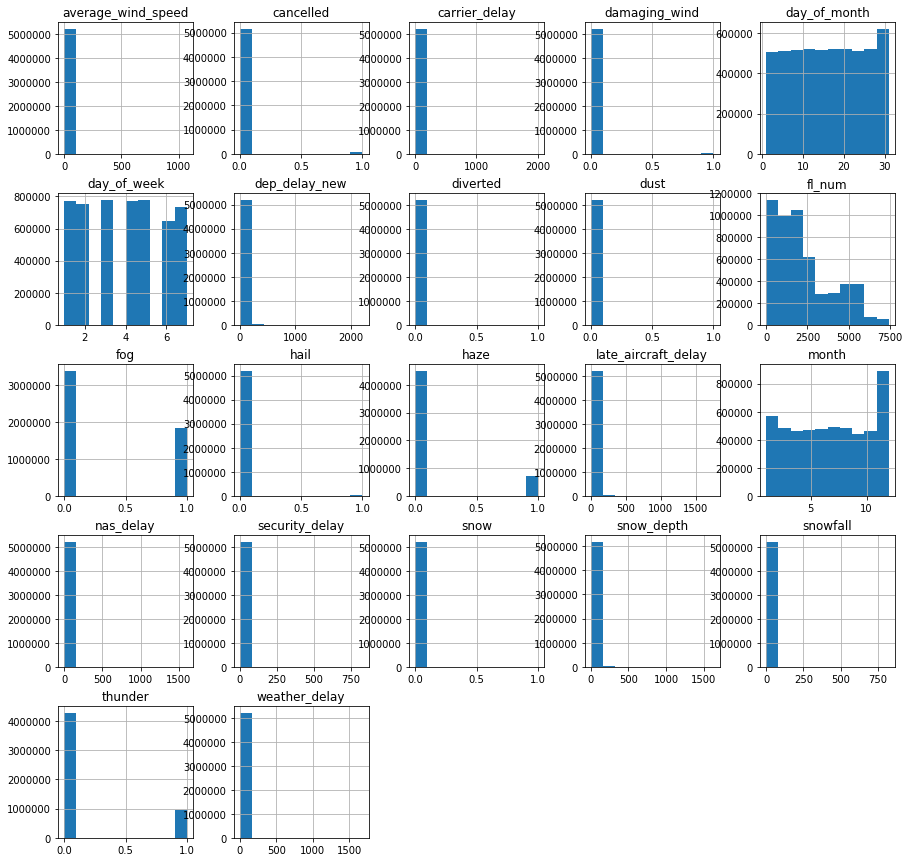

In [29]:
data.hist(figsize=(15, 15));

Plotting classes

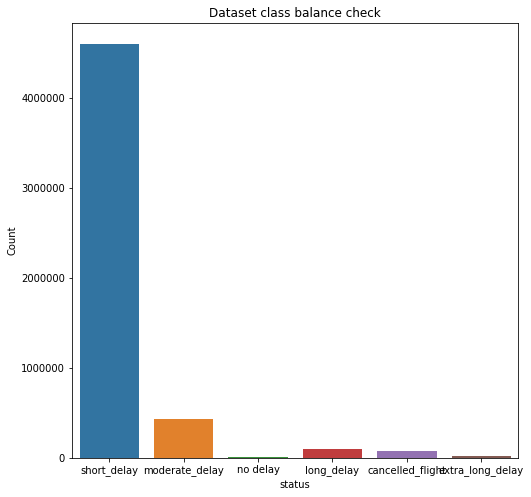

In [245]:
plt.figure(figsize=(8, 8))
ax = sns.countplot(x = data.status)
ax.set_title('Dataset class balance check')
ax.set_ylabel('Count')
plt.show()

huge imbalance here

Day / delay

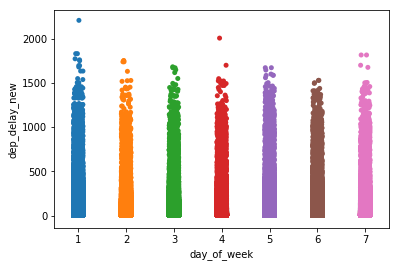

In [30]:
sns.stripplot(x="day_of_week", y="dep_delay_new", data=data, jitter=True)

Month / Delay

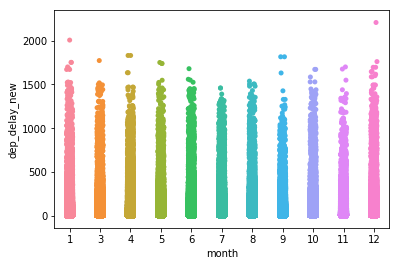

In [31]:
sns.stripplot(x="month", y="dep_delay_new", data=data, jitter=True)

/Users/bulhakovdmytro/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: The axisbg attribute was deprecated in version 2.0. Use facecolor instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


Text(0.5,1,'Delays in time')

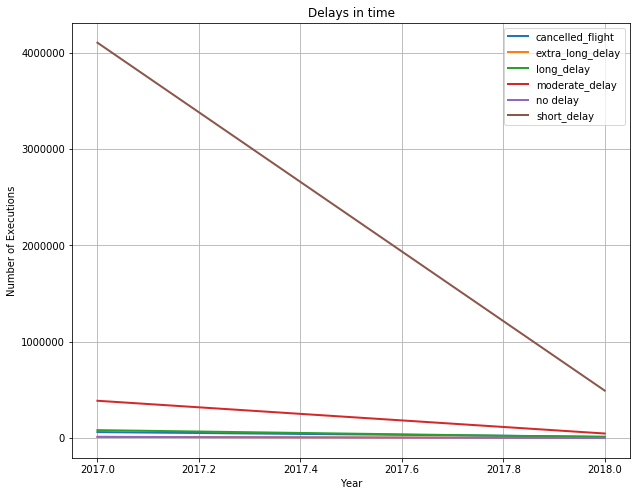

In [339]:
plot_df = data.copy()
plot_df['fl_date'] = pd.to_datetime(plot_df['fl_date'], dayfirst=True, infer_datetime_format = True)
plot_df.set_index('fl_date', inplace=True)
# set Race as categorical
plot_df['status'] = plot_df['status'].astype('category')

grouped = plot_df.groupby('status')

plt.clf()
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, axisbg='w', frame_on=True)

for key, group in grouped:
    plot_df = group.groupby(lambda x: x.year).count()
    plot_df['status'].plot(label=key, ax=ax, lw=2.)

# label x and y axis
plt.xlabel("Year")
plt.ylabel("Number of Executions")
# turn off background grid
ax.grid(b=None)
# show a semi-transparent legend
leg = ax.legend(loc='best')
leg.get_frame().set_alpha(0.75)
# set a title
plt.title('Delays in time')

## Additional preprocessing

In [306]:
data2 = data[data['origin'] == 'ALB']

In [307]:
working_df = data2

In [308]:
def additional_preprocessing(data_df):
    data_info = data_df.copy()
    data_info = data_info.drop(['cancellation_code', 'cancelled', 'carrier_delay', 'dep_delay_new', 'late_aircraft_delay', 'nas_delay', 'security_delay', 'weather_delay', 'diverted', 'origin_city_name', 'dest_city_name'], axis = 1)
    
    return data_info

In [309]:
working_df = additional_preprocessing(working_df)

## Processing

In [310]:
def process_data(data_df):
    data_info = data_df.copy()
    data_info = pd.get_dummies(data_info, columns=['origin', 'dest', 'carrier'])
    le = LabelEncoder()
    le.fit(np.unique(data_info['status'].values))
    data_info['status'] = le.transform(data_info['status'].values)
    data_info = data_info.drop(['fl_date'], axis=1)
    
    # hh2['fl_date'] = (hh2['fl_date'] - hh2['fl_date'].min())  / np.timedelta64(1,'D')
    return data_info

In [311]:
working_df = process_data(working_df)

## Train test split

In [312]:
X_train, X_test, y_train, y_test = train_test_split(working_df.loc[:, working_df.columns != 'status'], working_df['status'], test_size = 0.3, random_state = RND_STATE)

## Due to huge dataset performing undersampling

In [ ]:
tl = TomekLinks(random_state = RND_STATE)
X_train, y_train = tl.fit_sample(X_train, y_train)

## Predictions

In [291]:
classifiers = []

In [292]:
class ModelTester():
    def __init__(self, parameters, model, scoring='f1_micro', njobs=-1, cv=10):
        self.cv = GridSearchCV(model, param_grid=parameters, scoring = scoring, n_jobs = njobs, cv = cv, verbose = 1)
    
    def test_model(self, Xtrain, ytrain, Xtest, ytest):
        self.cv.fit(Xtrain, ytrain);
        print('Best score cv: ', self.cv.best_score_)
        print('Params: ', self.cv.best_params_)
    
        y_predicted = self.cv.predict(Xtest)
        print('Score on test sample:', f1_score(ytest, y_predicted, average='micro'))
        
    def best_estimator(self):
        return self.cv.best_estimator_

### Random Forest

In [295]:
param = {'criterion':['gini', 'entropy'], 'max_features':[1, 2, 3, 4, 5, 'log2', 'auto'],
         'max_depth':[2, 4, 8, 16, 32, 64], 'class_weight':['balanced', None]}

mt = ModelTester(parameters = param, model = RandomForestClassifier(random_state=RND_STATE))
mt.test_model(X_train, y_train, X_test, y_test)
rf_clf = mt.best_estimator()
classifiers.append({'name': 'Random Forest Classifier', 'clf': rf_clf})

Fitting 3 folds for each of 168 candidates, totalling 504 fits


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 376 tasks      | elapsed:   10.8s


Best score cv:  0.9311305732484076
Params:  {'class_weight': None, 'criterion': 'entropy', 'max_depth': 16, 'max_features': 4}
Score on test sample: 0.8761799000555247


[Parallel(n_jobs=-1)]: Done 504 out of 504 | elapsed:   14.2s finished


### SVC

In [296]:
param = {'C': np.linspace(0.01, 0.03, num=3), 
              'class_weight':['balanced', None], 'kernel':['linear'],
              'decision_function_shape' : ['ovo', 'ovr', None]}

mt = ModelTester(parameters = param, model = SVC(random_state=RND_STATE, cache_size=2048))
mt.test_model(X_train, y_train, X_test, y_test)
svc_clf = mt.best_estimator()
classifiers.append({'name': 'SVC', 'clf': svc_clf})

Fitting 3 folds for each of 18 candidates, totalling 54 fits


KeyboardInterrupt: 

### AdaBoostClassifier

In [297]:
param = {'algorithm': ['SAMME.R', 'SAMME'], 'learning_rate': [0.1, 0.3, 0.6, 0.8, 1.0]}
mt = ModelTester(parameters = param, model = AdaBoostClassifier(random_state=RND_STATE))
mt.test_model(X_train, y_train, X_test, y_test)
adc_clf = mt.best_estimator()
classifiers.append({'name': 'AdaBoost Classifier', 'clf': adc_clf})

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    5.6s finished


Best score cv:  0.9305997876857749
Params:  {'algorithm': 'SAMME.R', 'learning_rate': 0.1}
Score on test sample: 0.8770127706829539


### Decision Tree Classifier

In [298]:
param = {'criterion': ['gini', 'entropy'], 'splitter': ['best', 'random'], 'max_features':[1, 2, 3, 4, 5, 'log2', 'auto'], 
         'class_weight' : ['balanced'], 'random_state':[RND_STATE], 'presort':[True, False]}

mt = ModelTester(parameters = param, model = DecisionTreeClassifier(random_state=RND_STATE))
mt.test_model(X_train, y_train, X_test, y_test)
dtc_clf = mt.best_estimator()
classifiers.append({'name': 'Decision Tree Classifier', 'clf': dtc_clf})

Fitting 3 folds for each of 56 candidates, totalling 168 fits


[Parallel(n_jobs=-1)]: Done 128 tasks      | elapsed:    2.1s


Best score cv:  0.8888004246284501
Params:  {'class_weight': 'balanced', 'criterion': 'gini', 'max_features': 4, 'presort': False, 'random_state': 100412, 'splitter': 'best'}
Score on test sample: 0.8484175458078845


[Parallel(n_jobs=-1)]: Done 168 out of 168 | elapsed:    2.8s finished


### K-Neighbors Classifier

In [299]:
param = {'n_neighbors': [30, 50, 65, 70], 'weights': ['uniform', 'distance'], 'algorithm':['auto', 'ball_tree', 'kd_tree', 'brute'], 
         'leaf_size' : [10, 15, 20], 'p':[1, 2]}

mt = ModelTester(parameters = param, model = KNeighborsClassifier())
mt.test_model(X_train, y_train, X_test, y_test)
knn_clf = mt.best_estimator()
classifiers.append({'name': 'K-Neighbors Classifier', 'clf': knn_clf})

Fitting 3 folds for each of 192 candidates, totalling 576 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    9.5s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   45.2s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 576 out of 576 | elapsed:  4.0min finished


Best score cv:  0.9305997876857749
Params:  {'algorithm': 'auto', 'leaf_size': 10, 'n_neighbors': 30, 'p': 1, 'weights': 'uniform'}
Score on test sample: 0.8770127706829539


### Gradient Boosting Classifier

In [300]:
param = {'loss': ['deviance'], 'max_features':[1, 2, 3, 4, 5, 'log2', 'auto'], 'presort':[True, False],
         'n_estimators':[200, 300], 'min_samples_leaf' : [3]}

mt = ModelTester(parameters = param, model = GradientBoostingClassifier(random_state=RND_STATE))
mt.test_model(X_train, y_train, X_test, y_test)
gbc_clf = mt.best_estimator()
classifiers.append({'name': 'Gradient Boosting Classifier', 'clf': gbc_clf})

Fitting 3 folds for each of 28 candidates, totalling 84 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done  84 out of  84 | elapsed:  4.3min finished


Best score cv:  0.9335191082802548
Params:  {'loss': 'deviance', 'max_features': 4, 'min_samples_leaf': 3, 'n_estimators': 300, 'presort': False}
Score on test sample: 0.8792337590227651


## Working with the results

In [301]:
def save_clfs(file_name, data_to_save):
    with open(file_name, 'wb') as f:
        pickle.dump(data_to_save, f)

In [302]:
def load_clfs(file_name):
    with open('data.pickle', 'rb') as f:
        return pickle.load(f)

In [303]:
save_clfs(CLF_FILE, classifiers)

### Results per classifier:

In [398]:
def print_importances_internal(data_df, imp_list):
    print('Top 5 features:')
    val_zip = zip(data_df.columns, imp_list) 
    for a, b, in sorted(val_zip, key = lambda zp_gb: zp_gb[1], reverse = True)[:5]:
        print("{0}: {1}".format(a, b))

In [399]:
def print_importances(data_df, model):
    if hasattr(model, 'feature_importances_'):
        print_importances_internal(data_df, model.feature_importances_)
    elif hasattr(model, 'coef_'):
        print_importances_internal(data_df, model.coef_.flatten())

In [400]:
results_data = []
for clf in log_progress(classifiers, every = 1):
    print('\n' + clf['name'])
    score = f1_score(clf['clf'].predict(X_test), y_test, average='micro')
    print('F1 score: ', score)
    results_data.append({'Classifier': clf['name'], 'F1 Score': score})
    print_importances(X_train, clf['clf'])

VBox(children=(HTML(value=''), IntProgress(value=0, max=5)))


Random Forest Classifier
F1 score:  0.8761799000555247
Top 5 features:
average_wind_speed: 0.17247399008790246
day_of_month: 0.1661492413957504
fl_num: 0.1500456010153745
month: 0.11912382489318092
day_of_week: 0.09742323035819492

AdaBoost Classifier
F1 score:  0.8770127706829539
Top 5 features:
day_of_month: 0.34
average_wind_speed: 0.14
fl_num: 0.1
carrier_DL: 0.1
month: 0.08

Decision Tree Classifier
F1 score:  0.8484175458078845
Top 5 features:
day_of_month: 0.16436351400298096
fl_num: 0.1615938708781539
average_wind_speed: 0.1613494223711255
month: 0.10977449497743812
day_of_week: 0.09773549546811296

K-Neighbors Classifier
F1 score:  0.8770127706829539

Gradient Boosting Classifier
F1 score:  0.8792337590227651
Top 5 features:
average_wind_speed: 0.1684720338499684
fl_num: 0.16270721466123553
day_of_month: 0.14894957025142838
month: 0.09549463829858008
day_of_week: 0.0931519940114888


Text(0.5,1,'Models and F1 score')

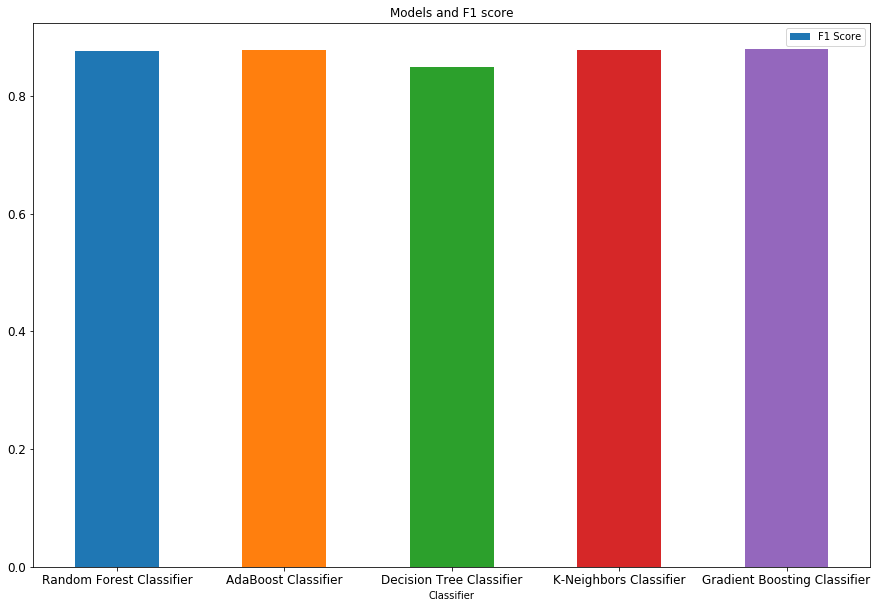

In [369]:
pd.DataFrame(results_data).plot(x='Classifier', y='F1 Score', kind = 'bar', figsize = (15, 10), fontsize = 12)
plt.xticks(rotation = 0)
plt.title('Models and F1 score', fontsize = 12)